In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import OrdinalEncoder

In [2]:
with open('imports-85.names', 'r') as file: 
    content = file.read() 
    
print(content)

1. Title: 1985 Auto Imports Database

2. Source Information:
   -- Creator/Donor: Jeffrey C. Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 19 May 1987
   -- Sources:
     1) 1985 Model Import Car and Truck Specifications, 1985 Ward's
        Automotive Yearbook.
     2) Personal Auto Manuals, Insurance Services Office, 160 Water
        Street, New York, NY 10038 
     3) Insurance Collision Report, Insurance Institute for Highway
        Safety, Watergate 600, Washington, DC 20037

3. Past Usage:
   -- Kibler,~D., Aha,~D.~W., \& Albert,~M. (1989).  Instance-based prediction
      of real-valued attributes.  {\it Computational Intelligence}, {\it 5},
      51--57.
	 -- Predicted price of car using all numeric and Boolean attributes
	 -- Method: an instance-based learning (IBL) algorithm derived from a
	    localized k-nearest neighbor algorithm.  Compared with a
	    linear regression prediction...so all instances
	    with missing attribute values were discarded.  This res

In [3]:
headers = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_doors', 'body_style', 'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type', 'num_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
df = pd.read_csv('imports-85.data', names=headers)
df

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


### replace ? to nan

In [4]:
df.replace('?', np.nan, inplace=True)

### Impute nulls

In [5]:
nulls_col = df.columns[df.isnull().sum() > 0]
nulls_col = df.columns

In [6]:
# Separate numeric and categorical features
numeric_features = df.select_dtypes(exclude='object')
categorical_features = df.select_dtypes(include='object')

In [7]:
numeric_features = [feat for feat in nulls_col if df[feat].dtype.kind in 'bifc'] 
categorical_features = [feat for feat in nulls_col if feat not in numeric_features]

In [8]:
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])


categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

In [9]:
df.isna().sum().sum()

np.int64(0)

### Scale 

In [10]:
mms = MinMaxScaler() 
x_scaled = mms.fit_transform(df[['price','horsepower']])

In [11]:
x_scaled

array([[2.07958890e-01, 2.62500000e-01],
       [2.82557966e-01, 2.62500000e-01],
       [2.82557966e-01, 4.41666667e-01],
       [2.19254257e-01, 2.25000000e-01],
       [3.06141701e-01, 2.79166667e-01],
       [2.51526737e-01, 2.58333333e-01],
       [3.12596197e-01, 2.58333333e-01],
       [3.42634427e-01, 2.58333333e-01],
       [4.65642222e-01, 3.83333333e-01],
       [2.08058190e-01, 4.66666667e-01],
       [2.80820217e-01, 2.20833333e-01],
       [2.93108584e-01, 2.20833333e-01],
       [3.93525644e-01, 3.04166667e-01],
       [3.96877017e-01, 3.04166667e-01],
       [4.82771461e-01, 3.04166667e-01],
       [6.36562236e-01, 5.58333333e-01],
       [8.98589941e-01, 5.58333333e-01],
       [7.88491137e-01, 5.58333333e-01],
       [8.19224468e-04, 0.00000000e+00],
       [2.92190060e-02, 9.16666667e-02],
       [3.61700015e-02, 9.16666667e-02],
       [1.12705427e-02, 8.33333333e-02],
       [3.12546547e-02, 8.33333333e-02],
       [7.04781292e-02, 2.25000000e-01],
       [2.758055

### Elbow, silhouette_score, calinski_harabasz_score

In [12]:
inertias = []
s_scores=[]
c_scores=[]

for k in range(2,11): 
    km= KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(x_scaled)

    inertias.append(km.inertia_)

    score = silhouette_score(x_scaled, km.labels_)
    s_scores.append(score)

    score = calinski_harabasz_score(x_scaled, km.labels_)
    c_scores.append(score)


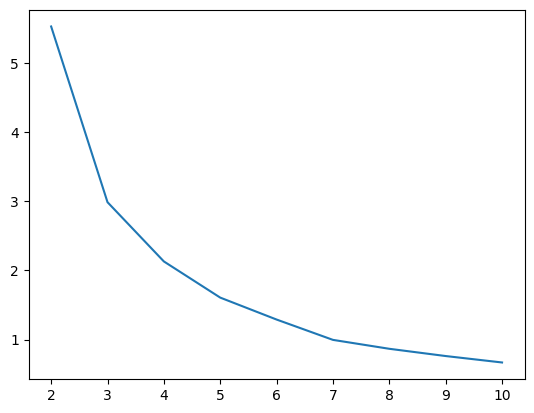

In [13]:
plt.plot(range(2,11), inertias);

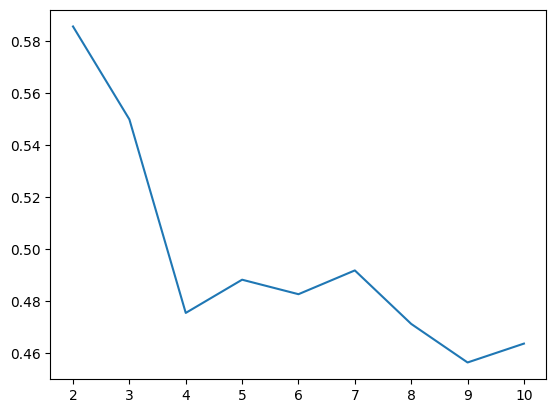

In [14]:
plt.plot(range(2,11), s_scores);

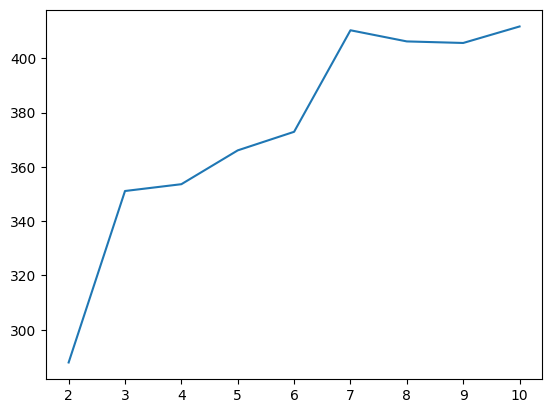

In [15]:
plt.plot(range(2,11), c_scores);

In [16]:
optimal_k = 3 
km = KMeans(n_clusters=optimal_k, random_state=42) 
km.fit(x_scaled) 

KMeans(n_clusters=3, random_state=42)

In [17]:
labels = km.labels_ 
labels

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [18]:
centers =km.cluster_centers_
centers

array([[0.09056746, 0.13907051],
       [0.30656047, 0.35594262],
       [0.7658277 , 0.56845238]])

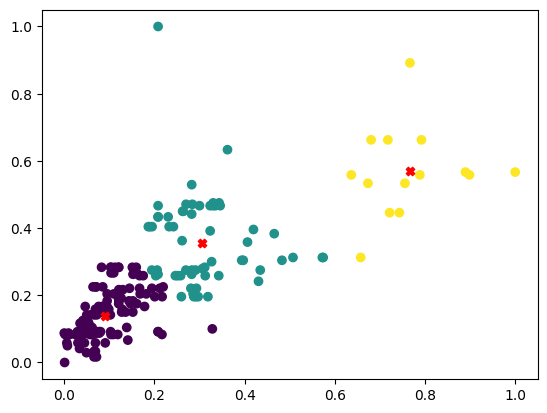

In [19]:
plt.scatter(x_scaled[:, 0], x_scaled[:, 1], c=km.labels_);
plt.scatter(centers[:,0], centers[:,1], c='r', marker='X');

Text(0.5, 1.0, 'Voronoi Diagram of KMeans Clusters')

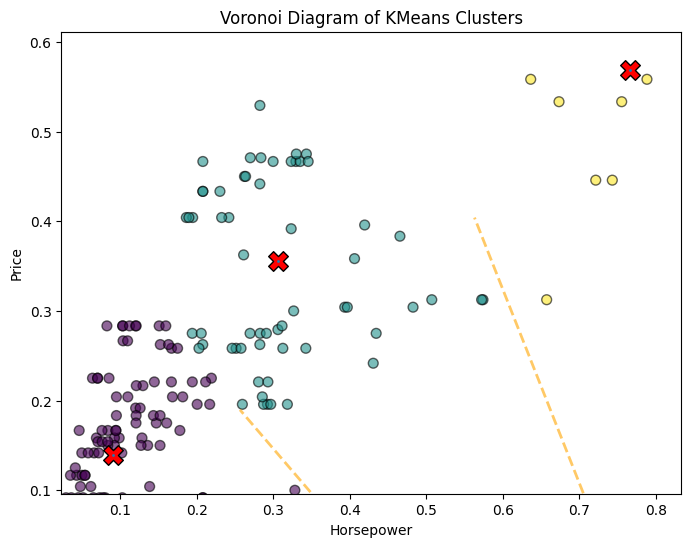

In [27]:
vor = Voronoi(centers)

fig, ax = plt.subplots(figsize=(8, 6))

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2);

ax.scatter(x_scaled[:, 0], x_scaled[:, 1], c=km.labels_, cmap='viridis', s=50, alpha=0.6, edgecolor='k'); 
ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, edgecolor='k');
ax.set_xlabel('Horsepower') 
ax.set_ylabel('Price') 
ax.set_title('Voronoi Diagram of KMeans Clusters')

##### boundaries (method 2)

Text(0.5, 1.0, 'KMeans Clustering with Decision Boundaries')

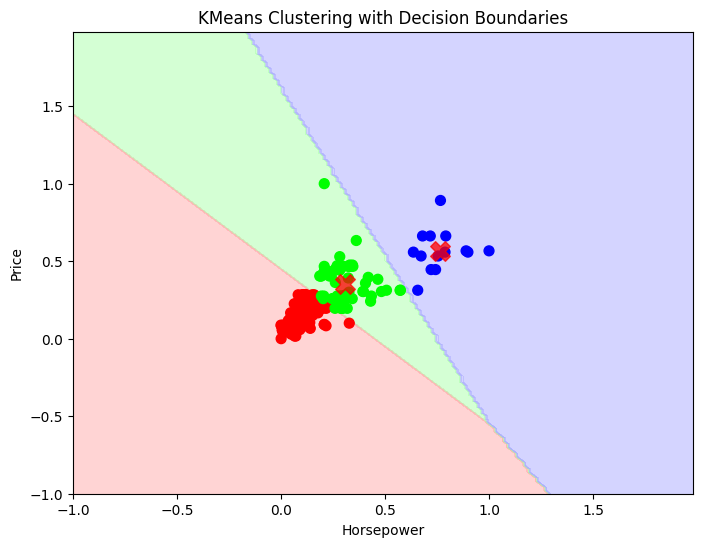

In [28]:
from matplotlib.colors import ListedColormap 
h = 0.02 #step size for the mesh grid

# Create custom color maps for the plot
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']) # for the background of the decision boundaries.
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF']) # for the scatter plot of the data points.

# range of the mesh grid based on the scaled data.
x_min, x_max = x_scaled[:, 0].min() - 1, x_scaled[:, 0].max() + 1 
y_min, y_max = x_scaled[:, 1].min() - 1, x_scaled[:, 1].max() + 1 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),  #function creates a mesh grid for plotting, generates 2D arrays representing the coordinates of the grid points.
                     np.arange(y_min, y_max, h)) 

# Predict cluster labels for each point in the mesh 
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])  # .ravel() - flatte n the xx and yy arrays into 1D
Z = Z.reshape(xx.shape) # reshapes the predicted labels to match the shape of the mesh grid

plt.figure(figsize=(8, 6)) 

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5) # fills the contours of the mesh grid with colors
plt.scatter(x_scaled[:, 0], x_scaled[:, 1], c=labels, cmap=cmap_bold, s=50) 
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X') 

plt.xlabel('Horsepower') 
plt.ylabel('Price') 
plt.title('KMeans Clustering with Decision Boundaries') 

### DBSCAN

In [22]:
dbs = DBSCAN(eps = 0.15, min_samples = 5) 
dbs.fit(x_scaled)

DBSCAN(eps=0.15)

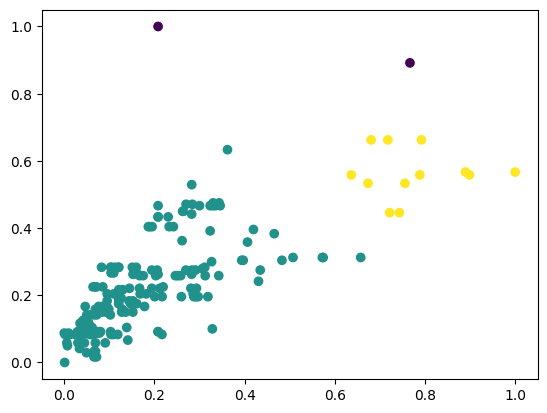

In [23]:
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=dbs.labels_); 

### Nearest-Neighbors

In [24]:
df_cleaned = pd.read_csv('mlb_batting_cleaned.csv')
df_cleaned

,Name,Age,Tm,Lg,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,CJ Abrams,21,WSN,NL,44,163,159,17,41,7,...,0.276,0.327,0.603,75,52,1,3,0,0,0
1,Albert Abreu,26,KCR,AL,1,0,0,0,0,0,...,0.000,0.000,0.000,0,0,0,0,0,0,0
2,José Abreu,35,CHW,AL,157,679,601,85,183,40,...,0.378,0.446,0.824,132,268,19,12,0,4,2
3,Ronald Acuna Jr.,24,ATL,NL,119,533,467,71,124,24,...,0.351,0.413,0.764,113,193,8,10,0,3,4
4,Willy Adames,26,MIL,NL,139,617,563,83,134,31,...,0.298,0.458,0.756,112,258,11,1,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,Juan Yepez,24,STL,NL,76,274,253,27,64,13,...,0.296,0.447,0.742,110,113,6,1,0,4,0
785,Jared Young,26,CHC,NL,6,22,19,2,5,2,...,0.364,0.368,0.732,108,7,0,0,0,0,0
786,Seby Zavala,28,CHW,AL,61,205,178,22,48,14,...,0.347,0.382,0.729,106,68,1,3,3,2,0
787,Bradley Zimmer,29,TOR,AL,23,14,13,3,1,0,...,0.143,0.077,0.220,-34,1,0,1,0,0,0


In [25]:
name = df_cleaned['Name']
X = df_cleaned.drop(columns='Name')

In [26]:
name

0             CJ Abrams
1          Albert Abreu
2            José Abreu
3      Ronald Acuna Jr.
4          Willy Adames
             ...       
784          Juan Yepez
785         Jared Young
786         Seby Zavala
787      Bradley Zimmer
788         Mike Zunino
Name: Name, Length: 789, dtype: object

In [27]:
categorical_features = X.select_dtypes(include='object').columns
categorical_features

Index(['Tm', 'Lg'], dtype='object')

In [28]:
X['Lg'] = np.where(X['Lg'] == 'NL',1,0)

In [29]:
oe = OrdinalEncoder()
oe.fit(X[['Tm']])
X['Tm'] = oe.transform(X[['Tm']])

In [30]:
numeric_features = X.select_dtypes(exclude='object').columns
numeric_features

Index(['Age', 'Tm', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP',
       'HBP', 'SH', 'SF', 'IBB'],
      dtype='object')

In [31]:
scaler = MinMaxScaler() 
x_scaled = scaler.fit_transform(X)

In [32]:
def nearest_neighbors(x_scaled, player_name, name_series):
    nn = NearestNeighbors(n_neighbors=3)
    nn.fit(x_scaled)

     
    player_index = name_series[name_series == player_name].index[0]

    
    dist, neighbors = nn.kneighbors([x_scaled[player_index]])

    closest_players = name_series.iloc[neighbors[0][1:]].values

    print(f"Input player name: {player_name}")
    print(f"the first closest player: {closest_players[0]}")
    print(f"the second closest player: {closest_players[1]}")
    

In [33]:
nearest_neighbors(x_scaled, 'José Abreu', name)

Input player name: José Abreu
the first closest player: J.D. Martinez
the second closest player: Xander Bogaerts
